In [5]:
import os
import pandas as pd
import numpy as np
import time
import cv2
import tensorflow as tf
import keras.backend as K
import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
##from tensorflow.keras.utils import multi_gpu_model

from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from tensorflow.keras import datasets, layers, models
from keras.layers import Activation, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

import pickle
import joblib
from joblib import dump, load

from collections import Counter
from imblearn.over_sampling import SMOTE 


## Data Preprocessing

In [41]:
def label_encoding_init(file_names):
    le = preprocessing.LabelEncoder()
    le.fit(file_names)
    dump(le, 'Task B Assets/Task_B_label_encoder.joblib') 

def SMOTE_preprocessing(file_names, labels):
    le = joblib.load('Task B Assets/Task_B_label_encoder.joblib')
    le.fit(file_names)
    le_file_names = le.transform(file_names).reshape(-1,1)
    print(le_file_names.shape)
    
    sm = SMOTE()
    SMOTE_file_names, SMOTE_labels = sm.fit_resample(le_file_names, labels)
    print("Distribution of image categories post-SMOTE:")
    print(Counter(list(SMOTE_labels)))
    
    SMOTE_file_names = le.inverse_transform(SMOTE_file_names)
    print('a')
    return SMOTE_file_names, SMOTE_labels

def image_processing(file_names):
    dataset_tumor=[]
    for file_name in file_names:
        file=cv2.imread(data_path+"/image/"+file_name)
        file_resize=cv2.resize(file,(128,128))/255.
        dataset_tumor.append(file_resize)
    tumor_data = np.array(dataset_tumor)
    return tumor_data

def preprocessing_data(data_path, file, status):

    data=pd.read_csv(data_path+file)
    file_names=list(data['file_name'])
    labels=data['label'].values.reshape(-1,1)
    
    if status == 'training':
        ohe = OneHotEncoder(handle_unknown = "ignore", sparse=False)
        ohe = ohe.fit(labels)
        
        print("Distribution of image categories:")
        print(Counter(list(data['label'])))
    
        label_encoding_init(file_names)
        file_names, labels = SMOTE_preprocessing(file_names, labels)
        x_train,x_test,y_train,y_test = train_test_split(file_names,labels,test_size=0.2)
        print('b')
        x_train = image_processing(x_train)
        x_test = image_processing(x_test)
        print('c')
        y_train = ohe.transform(np.array(y_train).reshape(-1,1))
        y_test = ohe.transform(np.array(y_test).reshape(-1,1))
        dump(ohe, 'Task B Assets/Task_B_one-hot_encoder.joblib') 

        
        return x_train, x_test, y_train, y_test

    
    elif status == 'testing':
        ohe = joblib.load('Task B Assets/Task_B_one-hot_encoder.joblib')
        y_test = ohe.transform(labels)
        x_test = image_processing(file_names) 
                              
        return x_test, y_test
    

def define_CNN():
    model = Sequential()
    
    #Conv2D is a 2D convolutional layer that applies 2d convolution to input signal composed of several input planes.
    #Kernel: is the filter that moves over the input layer to obtain a matrix of dot products based on the kernel size.
    #Strides metric: determines the shift of the kernel filter as it convolves around the input volume. 
    #Higher stride means larger shifts which lead to a smaller output volume. 
    #It is important to for the stride to be small enough that we capture significant features but not too small as this could lead to overfitting.
    #Padding: refers to the amount of pixels added to an image when it is being processed by the kernel. 
    #This helps provide more space for the kernel to cover the image.
    #Activation: refers to activation function used to product output layer. Here I use ReLU as it is simple and doesn't suffer from vanishing gradients
    
    model.add(Conv2D(32, kernel_size=(31,31), strides=(1,1), padding='same', activation='relu', input_shape=(128,128,3)))
    #MaxPooling reduces the size of the output matrix by obtaining the largest value from the a given pooling matrix 
    model.add(MaxPooling2D(pool_size=(2,2)))
    #Batch Normalization helps reduce the internal covariate shift of the network. 
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
              
    model.add(Conv2D(64, kernel_size=(27,27), strides=(1,1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
              
    model.add(Conv2D(128, kernel_size=(21,21), strides=(2,2), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
              
    #Flatten layer converts data into a 1-dimensional array for inputting it to the next layer. 
    #We flatten the output of the convolutional layers to create a single long feature vector 
    #So basically after our layers of pooling, we want to extract the data so we can feed it into our neural network
    model.add(Flatten())
    
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(4, activation='softmax'))
    model.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.001),  metrics=['acc'])
    
    return model
    
'''
def train_CNN(x_train,y_train):
    model = define_CNN()
    history1 = model.fit(x_train,y_train,epochs=50,batch_size=32,shuffle=True,validation_split=0.1)
    

    plt.plot(history1.history['acc'])
    plt.plot(history1.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history1.history['loss'])
    plt.plot(history1.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    model.save('Task B Assets/Task_B_CNN_Model')
    
    return model
'''
def train_CNN(x_train, y_train):
    kf = KFold(n_splits=5,shuffle=True)
    k_number = 0
    
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_f1score = []
    
    
    print("CNN training with 5-Fold Cross Validation.")
    for train_index, test_index in kf.split(x_train_val):
        k_number += 1
        x_train, x_val = x_train_val[train_index], x_train_val[test_index]
        y_train, y_val = y_train_val[train_index], y_train_val[test_index]
        
        model = define_CNN()
        
        
        history1 = model.fit(x_train,y_train,epochs=50,batch_size=32,shuffle=True,validation_split=0.1)
        
        acc_history = history1.history['acc']
        val_acc_history = history1.history['val_acc']
        loss_history = history1.history['loss']
        val_loss_history = history1.history['val_loss']

        print("The highest validation acc is {}".format(np.max(val_acc_history )))

        result=model.predict(x_val)
        result_class = tf.one_hot(np.argmax(result, axis=1), depth = 4)
        
        ohe = joblib.load('Task B Assets/Task_B_one-hot_encoder.joblib')
        result_class = ohe.inverse_transform(result_class)
        y_val_class = ohe.inverse_transform(y_val)

        val_accuracy.append(accuracy_score(result_class, y_val_class))
        val_precision.append(precision_score(result_class, y_val_class,average='micro'))
        val_f1score.append(f1_score(result_class, y_val_class,average='micro'))
        val_recall.append(recall_score(result_class, y_val_class,average='micro'))

        average_val_accuracy=sum(val_accuracy)/len(val_accuracy)
        average_val_precision=sum(val_precision)/len(val_precision)
        average_val_recall=sum(val_recall)/len(val_recall)
        average_val_f1score=sum(val_f1score)/len(val_f1score)
        
        print("CNN 5-Fold CV:")
        print("Average Acc: %.4f" %(average_val_accuracy))
        print("Average Precision: %.4f" %(average_val_precision))
        print("Average recall: %.4f" %(average_val_recall))
        print("Average F1 Score: %.4f \n" %(average_val_f1score))
        
    model.save('Task B Assets/Task_B_CNN_Model')


def test_model(x_test, y_test):
    print(y_test.shape)
    loaded_model = keras.models.load_model('Task B Assets/Task_B_CNN_Model')
    result=loaded_model.predict(x_test)
    result_class = tf.one_hot(np.argmax(result, axis=1), depth = 4)
    #y_test_class = np.argmax(y_test, axis=1)

    
    ohe = joblib.load('Task B Assets/Task_B_one-hot_encoder.joblib')
    result_class = ohe.inverse_transform(result_class)
    y_test_class = ohe.inverse_transform(y_test)
    
    acc = sklearn.metrics.accuracy_score(result_class, y_test_class)
    print("Accuracy for test data:", acc)
    
    plt.figure(figsize = (7,7))
    ConfusionMatrixDisplay.from_predictions(y_test_class, result_class, cmap = 'Blues')
    plt.xticks(rotation=45)
    plt.show()
    print(loaded_model.summary())
    print(classification_report(y_test_class, result_class))

## Data Preprocessing (Training)

In [40]:
data_path="dataset/"
file = "label.csv"

x_train_val, x_test, y_train_val, y_test = preprocessing_data(data_path, file, 'training')

Distribution of image categories:
Counter({'glioma_tumor': 860, 'meningioma_tumor': 855, 'pituitary_tumor': 831, 'no_tumor': 454})
(3000, 1)
Distribution of image categories post-SMOTE:
Counter({'meningioma_tumor': 860, 'no_tumor': 860, 'glioma_tumor': 860, 'pituitary_tumor': 860})
a
b


C:\Software\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c


In [37]:
print(x_train_val.shape)
print(y_train_val.shape)
print(x_test.shape)
print(y_test.shape)

(2752, 128, 128, 3)
(2752, 4)
(688, 128, 128, 3)
(688, 4)


## Training and Validation (KFold CV)

In [43]:
#Uncomment and run to see full training process.
#Model is saved as to ease model testing.

model = train_CNN(x_train_val, y_train_val)

CNN training with 5-Fold Cross Validation.
Epoch 1/50
62/62 [==============================] - 5s 71ms/step - loss: 2.1568 - acc: 0.3960 - val_loss: 6.0944 - val_acc: 0.2036
Epoch 2/50
62/62 [==============================] - 4s 69ms/step - loss: 1.2087 - acc: 0.4631 - val_loss: 1.4048 - val_acc: 0.3032
Epoch 3/50
62/62 [==============================] - 4s 69ms/step - loss: 1.1463 - acc: 0.4975 - val_loss: 1.2073 - val_acc: 0.4253
Epoch 4/50
62/62 [==============================] - 4s 69ms/step - loss: 1.1113 - acc: 0.5131 - val_loss: 1.1157 - val_acc: 0.5339
Epoch 5/50
62/62 [==============================] - 4s 69ms/step - loss: 1.0842 - acc: 0.5470 - val_loss: 1.2078 - val_acc: 0.4977
Epoch 6/50
62/62 [==============================] - 4s 70ms/step - loss: 1.0338 - acc: 0.5722 - val_loss: 1.1193 - val_acc: 0.5385
Epoch 7/50
62/62 [==============================] - 4s 69ms/step - loss: 1.0223 - acc: 0.5803 - val_loss: 1.0651 - val_acc: 0.5747
Epoch 8/50
62/62 [======================

## Testing (using splitted sample data)

(688, 4)
Accuracy for test data: 0.8313953488372093


<Figure size 504x504 with 0 Axes>

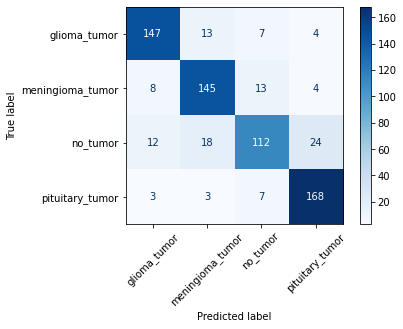

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 128, 128, 32)      92288     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
dropout_95 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 64, 64, 64)        1493056   
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 32, 32, 64)      

In [44]:
test_model(x_test, y_test)

# TO DO!!!

In [7]:
#SMOTE sampling
#add cross validation
#tidy up functions
#make version without SMOTE(task A makes sense, task B not so much)